<a href="https://colab.research.google.com/github/sv650s/amazon-review-classification/blob/master/notebooks/deep_learning/2.0-CNN32-prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Layer CNN x 32 Filters (unbalanced weights)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
sys.path.append(DRIVE_DIR)


%tensorflow_version 2.x


import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/device:GPU:0'

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight


import pandas as pd
import numpy as np
from IPython.display import SVG
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging
import importlib
import json

import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu
import util.keras_util as ku
import util.report_util as ru

import random

RSTATE = 1
# fix random seeds
tf.compat.v1.reset_default_graph()
tf.compat.v1.set_random_seed(RSTATE)
random.seed(RSTATE)
np.random.seed(RSTATE)


logging.basicConfig(level=logging.INFO)

%matplotlib inline
sns.set()



DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
LABEL_COLUMN = "star_rating"
REVIEW_COLUMN = "review_body"

SAMPLE_SIZE = "200k"

LEARNING_RATE = 0.01
# first layer filter
FILTER1 = 32
# Network Settings
KERNEL_SIZE = 3
PATIENCE = 4
PLATEAU_PATIENCE = 2
BALANCE_CLASS_WEIGHTS = False
MODEL_VERSION = 1
ENVIRONMENT = "2.0-CNN32-prototype.ipynb"



# length of our embedding - 300 is standard
EMBED_SIZE = 300
EPOCHS  = 20
BATCH_SIZE = 128

# From EDA, we know that 90% of review bodies have 100 words or less, 
# we will use this as our sequence length
MAX_SEQUENCE_LENGTH = 100

DEBUG = False

MODEL_NAME = f"CNN{FILTER1}"
ARCHITECTURE = f"1x{FILTER1}"
FEATURE_SET_NAME = "embedding_random"
REPORT_FILE = "dl_prototype-report.csv"

if DEBUG:
  DATA_FILE = f'{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-test-preprocessed.csv'
  MODEL_NAME = f'test-{MODEL_NAME}'
  REPORT_FILE = f'test-{REPORT_FILE}'
else:
  DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-{SAMPLE_SIZE}-with_stop_nonlemmatized-preprocessed.csv"

ku.ModelWrapper.set_report_filename(REPORT_FILE)

directory, INBASENAME = fu.get_dir_basename(DATA_FILE)
DESCRIPTION = f"1 Layer CNN with {FILTER1} filters, kernel size {KERNEL_SIZE} (unbalanced weights)"





start_time = datetime.now()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df = pd.read_csv(f"{DATA_FILE}")

In [4]:
df.head()

,star_rating,helpful_votes,total_votes,review_headline_orig,review_headline,review_body_orig,review_body,review_date
0,3,0,0,love polka dots,love polka dots,Best quality,best quality,2015-08-31
1,5,0,0,Five Stars,five stars,Very good quality for the price.,very good quality for the price,2015-08-31
2,5,0,0,but the case works great. Fits great and very ...,but the case works great fits great and very slim,I wish the bottom and top edges were a little ...,i wish the bottom and top edges were a little ...,2015-08-31
3,5,0,0,Perfect,perfect,Just finished using it while on a trip. Loved ...,just finished using it while on a trip loved b...,2015-08-31
4,1,0,0,cheaply made!,cheaply made,low quality earbuds! They do not stay in the e...,low quality earbuds they do not stay in the ea...,2015-08-31


In [0]:
rating = df[LABEL_COLUMN]
reviews = df[REVIEW_COLUMN]

**Preprocessing**

In [6]:
# one hot encode ratings
print(rating.shape)
print(type(rating))
y = OneHotEncoder().fit_transform(rating.values.reshape(len(rating), 1)).toarray()
print(y.shape)

(199538,)
<class 'pandas.core.series.Series'>
(199538, 5)


In [7]:


t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(reviews)


reviews_sequences = t.texts_to_sequences(reviews)
reviews_padded = sequence.pad_sequences(reviews_sequences, maxlen=MAX_SEQUENCE_LENGTH)

print("Vocabulary size={}".format(len(t.word_counts)))
print("Number of Documents={}".format(t.document_count))


X_train, X_test, y_train, y_test = train_test_split(reviews_padded, y, random_state=RSTATE)

Vocabulary size=57429
Number of Documents=199538


# Build our Model

In [0]:
model = Sequential()
model.add(Embedding(len(t.word_counts)+1, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=FILTER1, kernel_size=KERNEL_SIZE, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
# model.add(Dense(250, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(learning_rate=LEARNING_RATE), 
              metrics=['categorical_accuracy'])


In [9]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          17229000  
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 32)           28832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 50, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 8005      
Total params: 17,265,837
Trainable params: 17,265,837
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
# reduce learning rate if we sense a plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              restore_best_weights=True,
                              patience = PLATEAU_PATIENCE,
                              verbose = 1)

early_stop = EarlyStopping(monitor='val_loss', 
                           patience=PATIENCE, 
                           verbose=1, 
                           restore_best_weights=True)

# weights = compute_class_weight('balanced', np.arange(1, 6), rating)
# weights_dict = {i: weights[i] for i in np.arange(0, len(weights))}
# print(f'class weights: {weights}')
# print(f'class weights_dict: {weights_dict}')


mw = ku.ModelWrapper(model, 
                     model_name = MODEL_NAME, 
                     architecture = ARCHITECTURE,
                     feature_set_name = FEATURE_SET_NAME,
                     label_column = LABEL_COLUMN, 
                     feature_column = REVIEW_COLUMN,
                     data_file = DATA_FILE,
                     sample_size_str = SAMPLE_SIZE, 
                     tokenizer=t,
                     description=DESCRIPTION,
                     batch_size = BATCH_SIZE,
                     model_version = MODEL_VERSION,
                     save_dir = DRIVE_DIR)

mw.add("environment", ENVIRONMENT)
mw.add("patience", PATIENCE)
mw.add("plateau_patience", PLATEAU_PATIENCE)
mw.add("embed_size", EMBED_SIZE)


network_history = mw.fit(X_train, y_train,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      # class_weight=weights_dict,
                      callbacks=[early_stop, reduce_lr])

INFO:util.keras_util:saved file basename: CNN32-1x32-embedding_random-sampling_none-200k-review_body-v1
INFO:util.keras_util:Creating drive/My Drive/Springboard/capstone/models/CNN32-1x32-embedding_random-sampling_none-200k-review_body-v1/1
INFO:util.keras_util:Number of training examples: 149653
INFO:util.keras_util:Computed class weight dictionary: {0: 1.4389711538461538, 1: 3.073903666427031, 2: 2.1801005171534706, 3: 1.1976072343149808, 4: 0.3722942969090118}
INFO:util.keras_util:Adding checkpoint callback...
INFO:util.keras_util:model: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f494e24a080>


Epoch 1/20
936/936 [==============================] - ETA: 0s - loss: 1.3347 - categorical_accuracy: 0.5184
Epoch 00001: val_loss improved from inf to 1.23498, saving model to drive/My Drive/Springboard/capstone/models/CNN32-1x32-embedding_random-sampling_none-200k-review_body-v1/checkpoints
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: drive/My Drive/Springboard/capstone/models/CNN32-1x32-embedding_random-sampling_none-200k-review_body-v1/checkpoints/assets


INFO:tensorflow:Assets written to: drive/My Drive/Springboard/capstone/models/CNN32-1x32-embedding_random-sampling_none-200k-review_body-v1/checkpoints/assets


936/936 [==============================] - 184s 197ms/step - loss: 1.3347 - categorical_accuracy: 0.5184 - val_loss: 1.2350 - val_categorical_accuracy: 0.5205 - lr: 0.0100
Epoch 2/20
936/936 [==============================] - ETA: 0s - loss: 1.2725 - categorical_accuracy: 0.5449
Epoch 00002: val_loss improved from 1.23498 to 1.23124, saving model to drive/My Drive/Springboard/capstone/models/CNN32-1x32-embedding_random-sampling_none-200k-review_body-v1/checkpoints
INFO:tensorflow:Assets written to: drive/My Drive/Springboard/capstone/models/CNN32-1x32-embedding_random-sampling_none-200k-review_body-v1/checkpoints/assets


INFO:tensorflow:Assets written to: drive/My Drive/Springboard/capstone/models/CNN32-1x32-embedding_random-sampling_none-200k-review_body-v1/checkpoints/assets


936/936 [==============================] - 183s 196ms/step - loss: 1.2725 - categorical_accuracy: 0.5449 - val_loss: 1.2312 - val_categorical_accuracy: 0.5190 - lr: 0.0100
Epoch 3/20
936/936 [==============================] - ETA: 0s - loss: 1.2430 - categorical_accuracy: 0.5507
Epoch 00003: val_loss improved from 1.23124 to 1.14883, saving model to drive/My Drive/Springboard/capstone/models/CNN32-1x32-embedding_random-sampling_none-200k-review_body-v1/checkpoints
INFO:tensorflow:Assets written to: drive/My Drive/Springboard/capstone/models/CNN32-1x32-embedding_random-sampling_none-200k-review_body-v1/checkpoints/assets


INFO:tensorflow:Assets written to: drive/My Drive/Springboard/capstone/models/CNN32-1x32-embedding_random-sampling_none-200k-review_body-v1/checkpoints/assets


936/936 [==============================] - 181s 194ms/step - loss: 1.2430 - categorical_accuracy: 0.5507 - val_loss: 1.1488 - val_categorical_accuracy: 0.5381 - lr: 0.0100
Epoch 4/20
936/936 [==============================] - ETA: 0s - loss: 1.1815 - categorical_accuracy: 0.5693
Epoch 00004: val_loss did not improve from 1.14883
936/936 [==============================] - 179s 191ms/step - loss: 1.1815 - categorical_accuracy: 0.5693 - val_loss: 1.2921 - val_categorical_accuracy: 0.5124 - lr: 0.0100
Epoch 5/20
936/936 [==============================] - ETA: 0s - loss: 1.1545 - categorical_accuracy: 0.5744
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00005: val_loss did not improve from 1.14883
936/936 [==============================] - 178s 190ms/step - loss: 1.1545 - categorical_accuracy: 0.5744 - val_loss: 1.2267 - val_categorical_accuracy: 0.5209 - lr: 0.0100
Epoch 6/20
936/936 [==============================] - ETA: 0s - loss: 0.9972 - catego

In [11]:

scores = mw.evaluate(X_test, y_test)



Number of test: 49885
Running model.evaluate on test set...
1559/1559 [==============================] - 6s 4ms/step - loss: 1.1537 - categorical_accuracy: 0.5338
Running model.predict on test set...
Unencode test set predictions...
Generating test set confusion matrix...
Calculating test set ROC AUC...
(49885, 5)
Getting test set classification report...
Running model.evaluate on training set...
4677/4677 [==============================] - 19s 4ms/step - loss: 1.0413 - categorical_accuracy: 0.5712
Running model.predict on training set...
Unencode training set predictions...
Generating training set confusion matrix...
Calculating training set ROC AUC...
(149653, 5)
Getting training set classification report...


AttributeError: ignored

In [14]:
print("Accuracy: %.2f%%" % (mw.test_scores[1]*100))
print("Accuracy: %.2f%%" % (mw.train_scores[1]*100))
print(f'Overall Score: {ru.calculate_metric(mw.test_crd)}')


mw.save(append_report=True)


INFO:util.report_util:calculating metric from dictionary
INFO:util.report_util:got all values to calculate


Accuracy: 53.38%
Accuracy: 57.12%
Overall Score: 0.41246180888861833
Saving to report file: drive/My Drive/Springboard/capstone/reports/dl_prototype-report.csv
Loading to append to: drive/My Drive/Springboard/capstone/reports/dl_prototype-report.csv
Saving report file...
Saving json config file: drive/My Drive/Springboard/capstone/models/CNN32-1x32-embedding_random-sampling_none-200k-review_body-v1/CNN32-1x32-embedding_random-sampling_none-200k-review_body-v1-model.json
Saving weights file: drive/My Drive/Springboard/capstone/models/CNN32-1x32-embedding_random-sampling_none-200k-review_body-v1/CNN32-1x32-embedding_random-sampling_none-200k-review_body-v1-weights.h5
Saving history file: drive/My Drive/Springboard/capstone/reports/CNN32-1x32-embedding_random-sampling_none-200k-review_body-v1-history.pkl
Saving model file: drive/My Drive/Springboard/capstone/models/CNN32-1x32-embedding_random-sampling_none-200k-review_body-v1/CNN32-1x32-embedding_random-sampling_none-200k-review_body-v1-m

INFO:tensorflow:Assets written to: drive/My Drive/Springboard/capstone/models/CNN32-1x32-embedding_random-sampling_none-200k-review_body-v1/1/assets
INFO:util.keras_util:Saving tokenizer file: drive/My Drive/Springboard/capstone/models/CNN32-1x32-embedding_random-sampling_none-200k-review_body-v1/CNN32-1x32-embedding_random-sampling_none-200k-review_body-v1-tokenizer.pkl


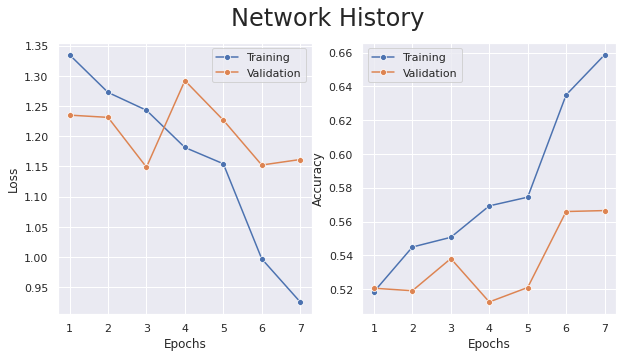


Confusion Matrix
[[ 3263  2790   512   275   118]
 [  774  1452   573   335    99]
 [  365  1498  1251  1005   435]
 [  174   995  1140  2878  3181]
 [  204  1334  1437  6010 17787]]

Classification Report
              precision    recall  f1-score   support

           1       0.68      0.47      0.56      6958
           2       0.18      0.45      0.26      3233
           3       0.25      0.27      0.26      4554
           4       0.27      0.34      0.31      8368
           5       0.82      0.66      0.74     26772

    accuracy                           0.53     49885
   macro avg       0.44      0.44      0.42     49885
weighted avg       0.62      0.53      0.56     49885



drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  w

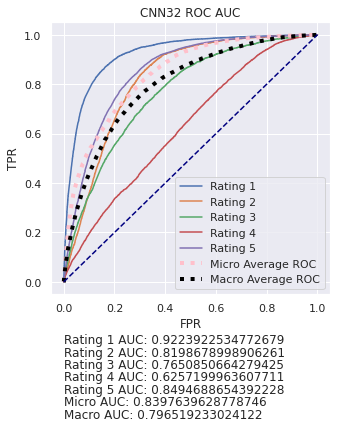

In [16]:
pu.plot_network_history(mw.network_history, "categorical_accuracy", "val_categorical_accuracy")
plt.show()

print("\nConfusion Matrix")
print(mw.test_confusion_matrix)

print("\nClassification Report")
print(mw.test_classification_report)

fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(mw.model_name, mw.test_roc_auc, mw.test_fpr, mw.test_tpr)


**Save off various files**

In [17]:
from tensorflow.keras.models import load_model

model_loaded = load_model(mw.model_file)
scores = model_loaded.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

# this takes too long for real models
if DEBUG == True:
  y_predict = model_loaded.predict(X_test)
  y_predict_unencoded = ku.unencode(y_predict)
  y_test_unencoded = ku.unencode(y_test)

  # classification report
  print(classification_report(y_test_unencoded, y_predict_unencoded))

  # confusion matrix
  print(confusion_matrix(y_test_unencoded, y_predict_unencoded))


1559/1559 [==============================] - 6s 4ms/step - loss: 1.1537 - categorical_accuracy: 0.5338
Accuracy: 53.38%


In [18]:
end_time = datetime.now()
print(f'Start Time: {start_time}\n' \
      f'End Time: {end_time}\n' \
      f'Total Duration: {round((end_time - start_time).total_seconds() / 60, 2)} mins')
print(datetime.now())

Start Time: 2020-05-15 05:55:50.481336
End Time: 2020-05-15 06:23:37.505356
Total Duration: 27.78 mins
2020-05-15 06:23:37.505595
